# Classificação de Texto

<div style="text-align:justify">
Este notebook apresenta uma aplicação prática das técnicas de classificação. O exemplo explorado nesse exemplo mostra como classificar dados textuais. Para isso isso vamos testar diferentes algoritmos de classificação e comparar seus resultados.
</div>

### Carregando Pacotes

In [11]:
import warnings, pandas, joblib

from matplotlib import pyplot

# machine learning algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

# dataset balancer
from imblearn.over_sampling import RandomOverSampler

# text vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# machine learning metrics report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Configurações

In [12]:
warnings.filterwarnings(action='ignore')
pyplot.rcParams['figure.figsize'] = (14, 8)
pandas.set_option('display.max_colwidth', 100)

### Dataset

<div style="text-align:justify">
O dataset que vamos utilizar para esse exemplo descreve os comentários de uma loja de aplicativos. Estes comentários são escritos por usuários do aplicativo em questão. Vale ressaltar que os textos dos comentário já estão tratados (sem acentos, em lowercase e sem caracteres especiais) e os dados já estão rotulados.
</div>

In [13]:
df = pandas.read_csv('datasets/app_reviews.csv')
df = df[~df['category'].isna()]
df = df.rename(columns={'trusted': 'review', 'category': 'label'})

reasons = ['Não estou conseguindo','Problema no cadastro','Bloqueio de conta','Dúvida']
df = df[~df['label'].isin(reasons)]

df.head()

,review,label
0,tem 7 meses q uso cartao e o limite nunca aumentapedi para fazer pagamentos antecipadodificil de...,Limite de crédito
1,fiz um deposito na minha conta mas nao aparece meu saldo em lugar nenhum precisa ter essa opcao ...,Depósito demora
2,simplesmente um lixo,Comentário detrator sem informação
3,ajuste de valor r 60000 nao depositarei mais nenhum centavo nessa conta a menos que a empresa ve...,Outro
4,nao consigo acessar minha conta o suporte nao me ajuda,Problema de acesso


In [14]:
print('Total de Linhas: {}'.format(df.count()))

Total de Linhas: review    1051
label     1051
dtype: int64


### Categorias - Geral

In [15]:
df['label'].value_counts()

Comentário detrator sem informação    173
Sugestão de funcionalidade            131
Aplicativo não funcional              119
Limite de crédito                      99
Difícil conseguir crédito              93
Problema de acesso                     91
Elogio                                 81
Problema com código no e-mail          69
Foto do documento                      59
Outro                                  59
Depósito demora                        41
Cartão não chegou                      36
Name: label, dtype: int64

### Categorias - Treino

In [16]:
df_tra = df.sample(frac=0.8, random_state=42)
df_tra['label'].value_counts()

Comentário detrator sem informação    146
Sugestão de funcionalidade            106
Aplicativo não funcional               93
Limite de crédito                      78
Difícil conseguir crédito              76
Problema de acesso                     68
Elogio                                 64
Problema com código no e-mail          55
Outro                                  49
Foto do documento                      45
Depósito demora                        35
Cartão não chegou                      26
Name: label, dtype: int64

### Categorias - Teste

In [17]:
df_tes = df.drop(df_tra.index)
df_tes['label'].value_counts()

Comentário detrator sem informação    27
Aplicativo não funcional              26
Sugestão de funcionalidade            25
Problema de acesso                    23
Limite de crédito                     21
Difícil conseguir crédito             17
Elogio                                17
Problema com código no e-mail         14
Foto do documento                     14
Outro                                 10
Cartão não chegou                     10
Depósito demora                        6
Name: label, dtype: int64

### Vectorizar Reviews

Exemplo:

- F1: eu gosto de pipoca
- F2: eu gosto de pipoca doce
- F3: eu não gosto de batata

<pre>
eu | gosto | de | pipoca | doce | não | batata | batata doce (vocabulario)
1  | 1     | 1  | 1      | 0    | 0   | 0      | 0
1  | 1     | 1  | 1      | 1    | 0   | 0      | 1
1  | 1     | 1  | 0      | 0    | 1   | 1      | 0
</pre>

In [18]:
documents = df_tra['review'].values

vectorizer = TfidfVectorizer(
    min_df=5,
    max_df=0.7,
    ngram_range=(1, 3),
    max_features=1000,
    stop_words=['a','o','de','do','da']
).fit(documents)

vectorizer

TfidfVectorizer(max_df=0.7, max_features=1000, min_df=5, ngram_range=(1, 3),
                stop_words=['a', 'o', 'de', 'do', 'da'])

In [19]:
vectorizer.vocabulary_

{'era': 272,
 'um': 780,
 'aplicativo': 48,
 'bom': 107,
 'mas': 427,
 'so': 714,
 'trava': 771,
 'para': 585,
 'funcionar': 364,
 'por': 615,
 'favor': 322,
 'resolvam': 679,
 'esse': 279,
 'problema': 636,
 'aplicativo bom': 49,
 'bom mas': 109,
 'por favor': 616,
 'esse problema': 285,
 'nao': 488,
 'consigo': 179,
 'acessar': 14,
 'minha': 462,
 'conta': 186,
 'nao consigo': 499,
 'consigo acessar': 180,
 'acessar minha': 16,
 'minha conta': 464,
 'nao consigo acessar': 500,
 'consigo acessar minha': 181,
 'acessar minha conta': 17,
 'meu': 444,
 'pede': 593,
 'cpf': 194,
 'senha': 702,
 'coloco': 159,
 'tudo': 774,
 'fala': 313,
 'que': 645,
 'estao': 292,
 'problemas': 639,
 'em': 257,
 'com': 160,
 'suporte': 724,
 'outro': 575,
 'isso': 389,
 'me': 429,
 'ajudem': 30,
 'fala que': 314,
 'me ajudem': 431,
 'estou': 295,
 'mesmo': 441,
 'eu': 303,
 'valor': 806,
 'muito': 473,
 'baixo': 96,
 'pouco': 624,
 'aumentar': 87,
 'usando': 800,
 'aumentou': 92,
 'atendente': 75,
 'no': 

### Modelo

In [20]:
X_tra = vectorizer.transform(documents)
y_tra = df_tra['label'].values

classifier = SGDClassifier(max_iter=1000).fit(X_tra, y_tra)
classifier

SGDClassifier()

### Avaliação

In [21]:
X_tes = vectorizer.transform(df_tes['review'].values)
y_tes = df_tes['label'].values

y_prd = classifier.predict(X_tes)
print(classification_report(y_tes, y_prd))

                                    precision    recall  f1-score   support

          Aplicativo não funcional       0.75      0.81      0.78        26
                 Cartão não chegou       0.89      0.80      0.84        10
Comentário detrator sem informação       0.77      0.74      0.75        27
                   Depósito demora       0.83      0.83      0.83         6
         Difícil conseguir crédito       0.68      0.76      0.72        17
                            Elogio       0.94      1.00      0.97        17
                 Foto do documento       1.00      0.93      0.96        14
                 Limite de crédito       0.85      0.81      0.83        21
                             Outro       0.38      0.50      0.43        10
     Problema com código no e-mail       0.87      0.93      0.90        14
                Problema de acesso       0.89      0.70      0.78        23
        Sugestão de funcionalidade       0.68      0.68      0.68        25

          

### Matriz de Confusão

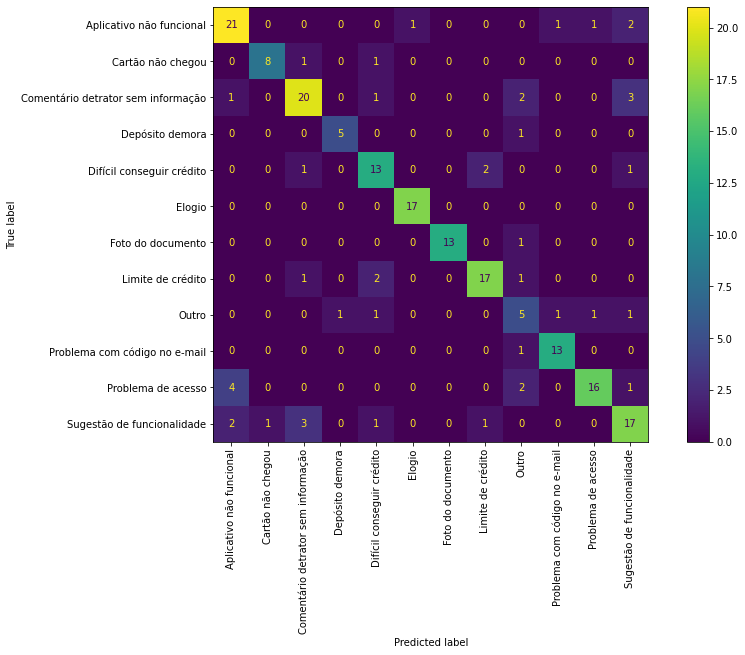

In [22]:
cm = confusion_matrix(y_tes, y_prd)
cmd = ConfusionMatrixDisplay(cm, display_labels=[
    'Aplicativo não funcional',
    'Cartão não chegou',
    'Comentário detrator sem informação',
    'Depósito demora',
    'Difícil conseguir crédito',
    'Elogio',
    'Foto do documento',
    'Limite de crédito',
    'Outro',
    'Problema com código no e-mail',
    'Problema de acesso',
    'Sugestão de funcionalidade'
])

cmd.plot()

pyplot.xticks(rotation=90)
pyplot.show()

### Savando Modelo

In [23]:
joblib.dump(vectorizer, 'models/vectorizer')
joblib.dump(classifier, 'models/classifier')

['models/classifier']